In [1]:
import numpy as np
import matplotlib.pyplot as plt

from argosim.antenna_utils import *
from argosim.plot_utils import *
from argosim.data_utils import *
from argosim.clean import *
from argosim.imaging_utils import *
from argosim.beam_utils import *
from argosim.metrics_utils import *

In [2]:
antenna = load_antenna_enu_txt('../configs/arrays/argos_pathfinder.enu.txt')

In [3]:
baselines = get_baselines(antenna)

In [4]:
# Multiband parameters
bandwidth = 2000e6
n_freqs = 128
f = 2000e6 # 2 GHz, lambda = 0.15 m

# Source tracking parameters
source_decl = 90./180*np.pi
array_lat = 35./180*np.pi # Heraklion latitud
track_time = 5
delta_t = 15/60 # 900 segs
t_0 = -0.5
n_times = int(track_time/delta_t)

track, freqs = uv_track_multiband(baselines, array_lat, source_decl, track_time, t_0, n_times, f, bandwidth, n_freqs, multi_band=False)
#track, freqs = uv_track_multiband(baselines, array_lat, source_decl, track_time, t_0, n_times, f, bandwidth, n_freqs)

#track_plot = np.reshape(track, (-1, 3))
print('The tracking is done for {} frequency bands'.format(n_freqs))
print('The tracking is done for {} time samples'.format(n_times))

The tracking is done for 128 frequency bands
The tracking is done for 20 time samples


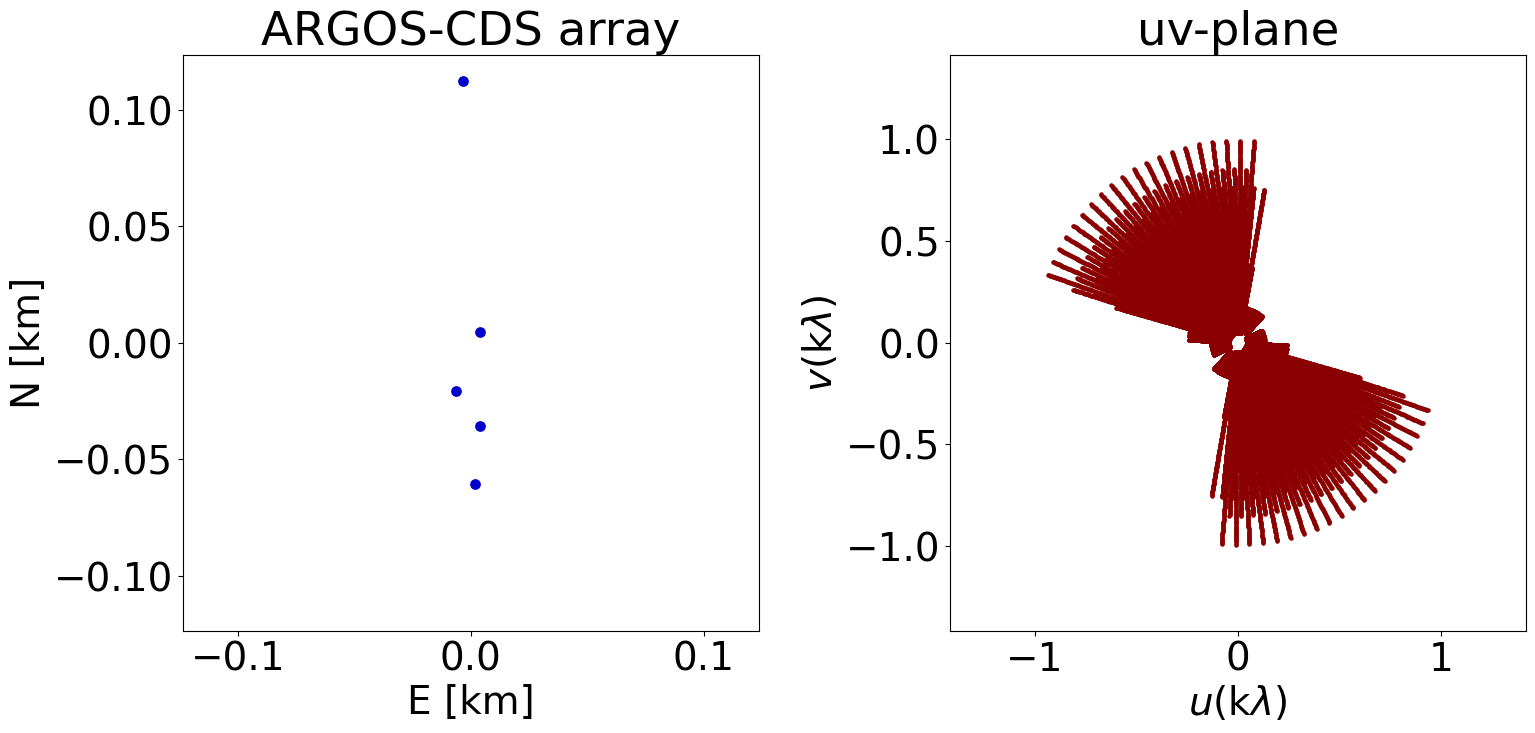

In [5]:
plt.rcParams.update({'font.size': 28})

fig, ax = plt.subplots(1,2, figsize=(16, 10))
plot_antenna_arr(antenna, ax=ax[0], fig=fig, title='ARGOS-CDS array',s=45,antenna_idx=False)
plot_baselines(track, ax=ax[1], fig=fig)
plt.tight_layout()
plt.savefig('../figures/argos_CDS_array_baseline.pdf',dpi=300,bbox_inches='tight')

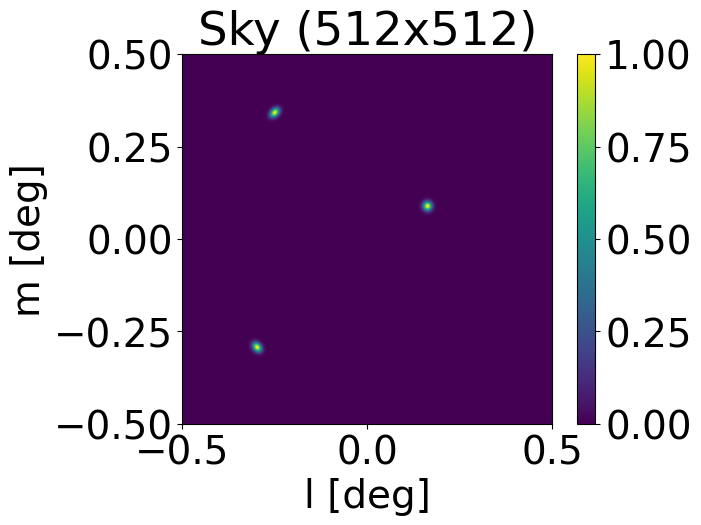

In [6]:
Npx = 512
fov_size = 1. # 3 degrees FOV from 6 m parabolic dishes.
sky = n_source_sky((Npx, Npx), fov_size, deg_size_list=[0.02, 0.02, 0.02], source_intensity_list=[.33]*3,seed=86, norm='max')
plot_sky(sky, (fov_size, fov_size))

# Single-band observation

In [7]:
observation_single, dirty_beam_single = simulate_dirty_observation(sky, track, fov_size, multi_band=False, sigma=0.2)

/Users/ec270266/Documents/Phd/Argos/repos/argosim/src/argosim/imaging_utils.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  uv_mask = jnp.zeros(sky_uv_shape, dtype=jnp.complex128)


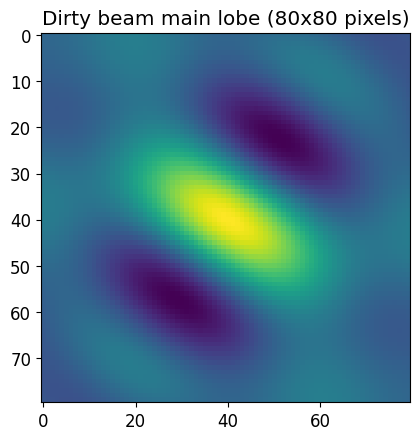

In [8]:
plt.rcParams.update({'font.size': 12})

main_lobe_px = 80
plt.imshow(dirty_beam_single[Npx//2-main_lobe_px//2:Npx//2+main_lobe_px//2,Npx//2-main_lobe_px//2:Npx//2+main_lobe_px//2])
plt.title('Dirty beam main lobe ({}x{} pixels)'.format(main_lobe_px, main_lobe_px))
plt.show()

In [9]:
I_clean_single, sky_model_single = clean_hogbom(observation_single, dirty_beam_single, 0.02, 400, 1e-3 , clean_beam_size_px=11)
I_clean_single = I_clean_single / np.max(I_clean_single)  # Normalize the image

Reached threshold at iteration 245


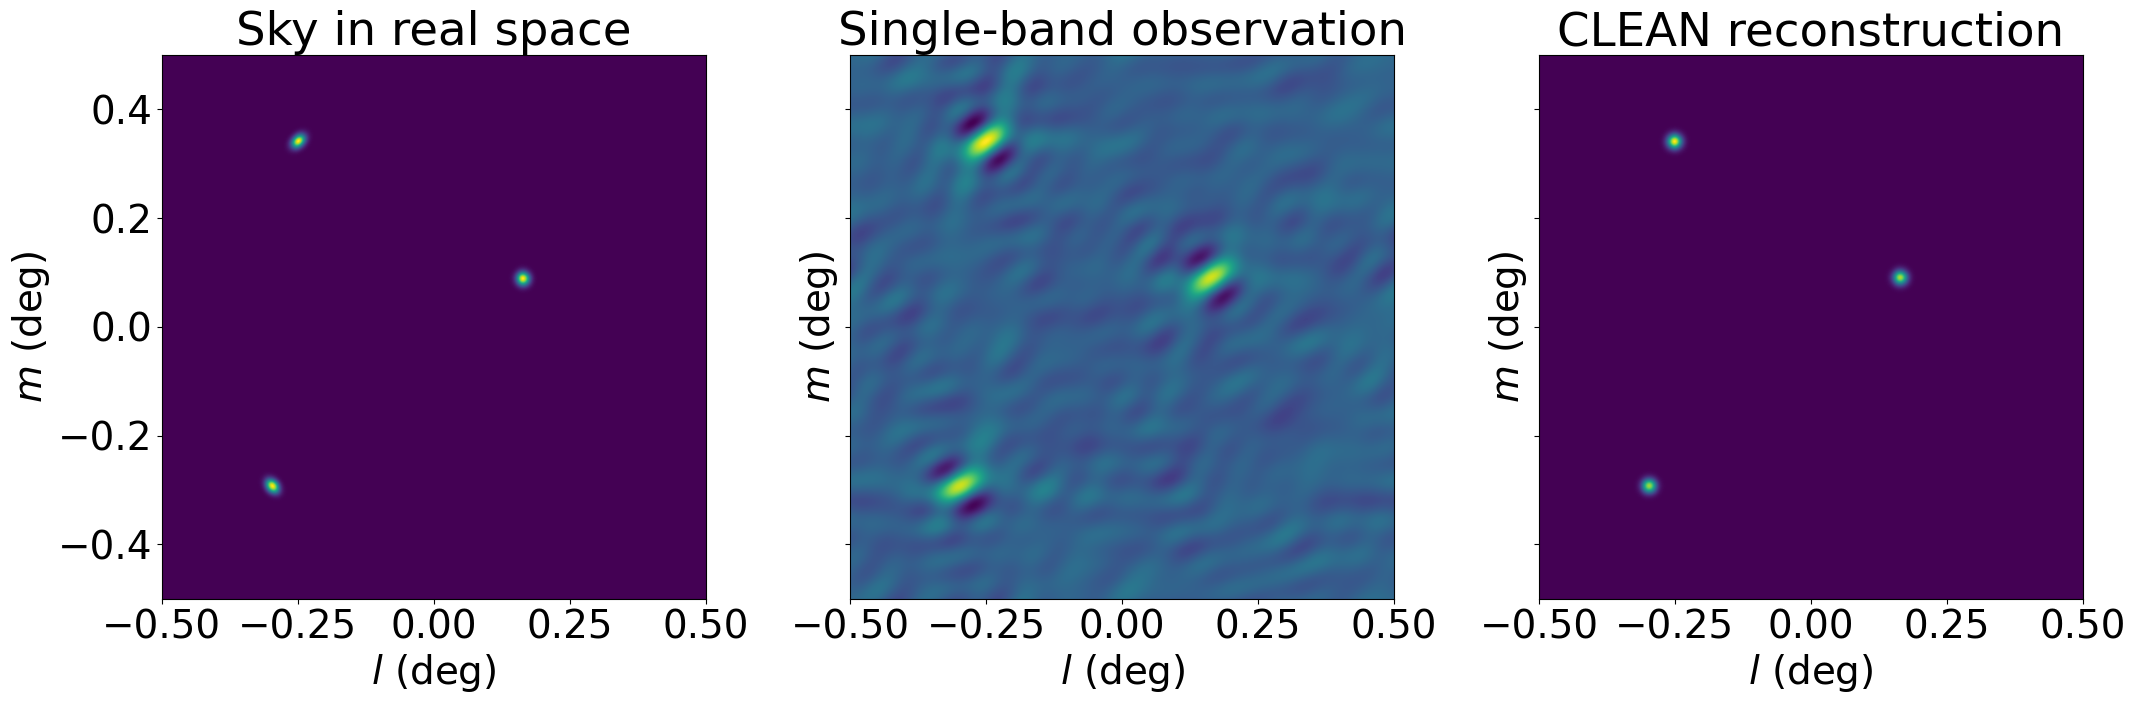

In [10]:
plt.rcParams.update({'font.size': 28})

fig, ax = plt.subplots(1,3, figsize=(22, 16), sharey='row')

ax[0].imshow(np.abs(sky), extent=[-fov_size / 2, fov_size / 2, -fov_size / 2, fov_size / 2], origin="lower")
ax[0].set_xlabel(r"$l$ (deg)")
ax[0].set_ylabel(r"$m$ (deg)")
ax[0].set_title("Sky in real space")
#ax[0,0].set_yticks([-50, 0, 50])
ax[1].imshow(observation_single, extent=[-fov_size / 2, fov_size / 2, -fov_size / 2, fov_size / 2], origin="lower")
ax[1].set_xlabel(r"$l$ (deg)")
ax[1].set_ylabel(r"$m$ (deg)")
ax[1].set_title("Single-band observation")
ax[2].imshow(I_clean_single, extent=[-fov_size / 2, fov_size / 2, -fov_size / 2, fov_size / 2], origin="lower")
ax[2].set_xlabel(r"$l$ (deg)")
ax[2].set_ylabel(r"$m$ (deg)")
ax[2].set_title("CLEAN reconstruction")
plt.tight_layout()
#plt.savefig('../figures/argos_CDS_observation.pdf',dpi=300, bbox_inches='tight')
plt.show()

# Beam metrics

## Between single-band reconstruction and sky

In [11]:
# from skimage.metrics import structural_similarity as ssim

metrics_single = compute_metrics(sky, I_clean_single)
print(metrics_single.keys())

print("CLEAN observation metrics")
print("MSE: ", metrics_single['mse'])
print("RMSE: ", metrics_single['rel_mse'])
print("SSIM: ", metrics_single['ssim'])
# Compute SSIM between sky and I_clean_single, using data_range for proper normalization
# print(ssim(sky, I_clean_single, data_range=I_clean_single.max() - I_clean_single.min()))

print('#' * 50)
# compute metrics with the observation
metrics_single_obs = compute_metrics(sky,observation_single)
print("Dirty observation metrics")
print("MSE:", metrics_single_obs['mse'])
print("RMSE:", metrics_single_obs['rel_mse'])
print("SSIM:", metrics_single_obs['ssim'])
# print(ssim(sky, np.array(observation_single), data_range=np.array(sky).max() - np.array(sky).min()))


dict_keys(['mse', 'rel_mse', 'residual', 'ssim'])
CLEAN observation metrics
MSE:  2.717105e-05
RMSE:  0.039846286
SSIM:  0.998450176834501
##################################################
Dirty observation metrics
MSE: 0.00054999016
RMSE: 0.8065594
SSIM: 0.6409889642306481


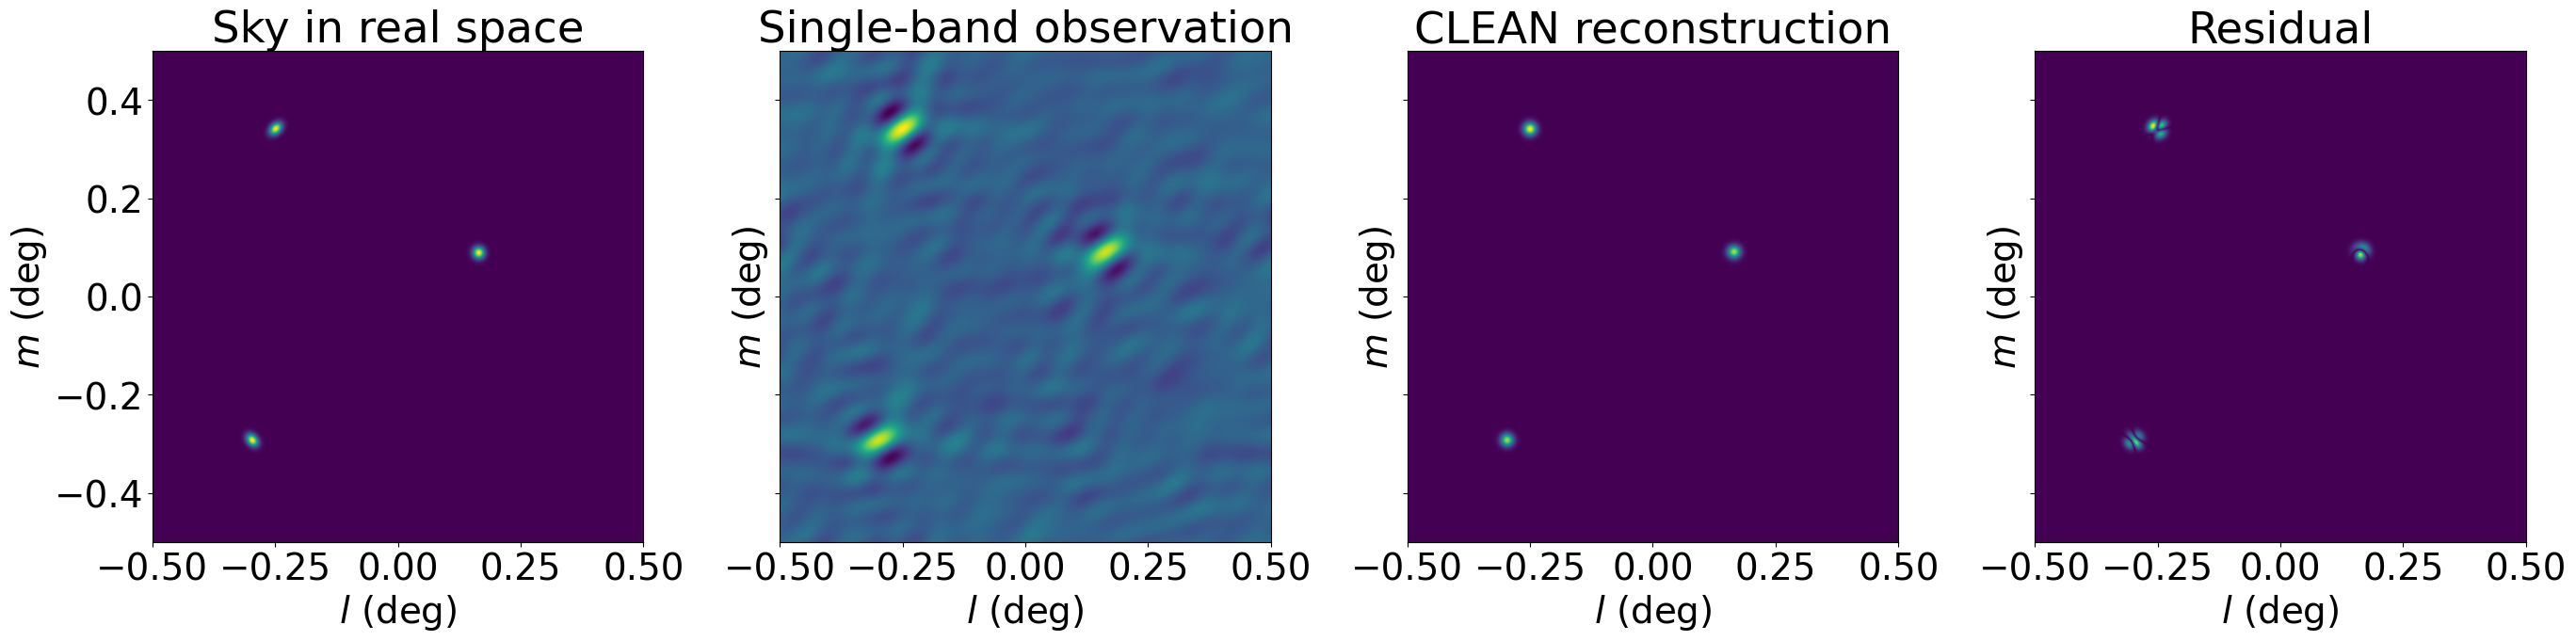

In [12]:
plt.rcParams.update({'font.size': 28})

fig, ax = plt.subplots(1,4, figsize=(28, 20), sharey='row')

ax[0].imshow(np.abs(sky), extent=[-fov_size / 2, fov_size / 2, -fov_size / 2, fov_size / 2], origin="lower")
ax[0].set_xlabel(r"$l$ (deg)")
ax[0].set_ylabel(r"$m$ (deg)")
ax[0].set_title("Sky in real space")
#ax[0,0].set_yticks([-50, 0, 50])
ax[1].imshow(observation_single, extent=[-fov_size / 2, fov_size / 2, -fov_size / 2, fov_size / 2], origin="lower")
ax[1].set_xlabel(r"$l$ (deg)")
ax[1].set_ylabel(r"$m$ (deg)")
ax[1].set_title("Single-band observation")
ax[2].imshow(I_clean_single, extent=[-fov_size / 2, fov_size / 2, -fov_size / 2, fov_size / 2], origin="lower")
ax[2].set_xlabel(r"$l$ (deg)")
ax[2].set_ylabel(r"$m$ (deg)")
ax[2].set_title("CLEAN reconstruction")
ax[3].imshow(metrics_single['residual'], extent=[-fov_size / 2, fov_size / 2, -fov_size / 2, fov_size / 2], origin="lower")
ax[3].set_xlabel(r"$l$ (deg)")
ax[3].set_ylabel(r"$m$ (deg)")
ax[3].set_title("Residual")
plt.tight_layout()
plt.savefig('../figures/argos_CDS_observation.pdf',dpi=300, bbox_inches='tight')
plt.show()

In [13]:
compute_beam_metrics(dirty_beam_single)

{'sll_db': -3.391129279825024,
 'fwhm': (19.631329428078143, 8.146834040673287),
 'eccentricity': 0.909825306853267}

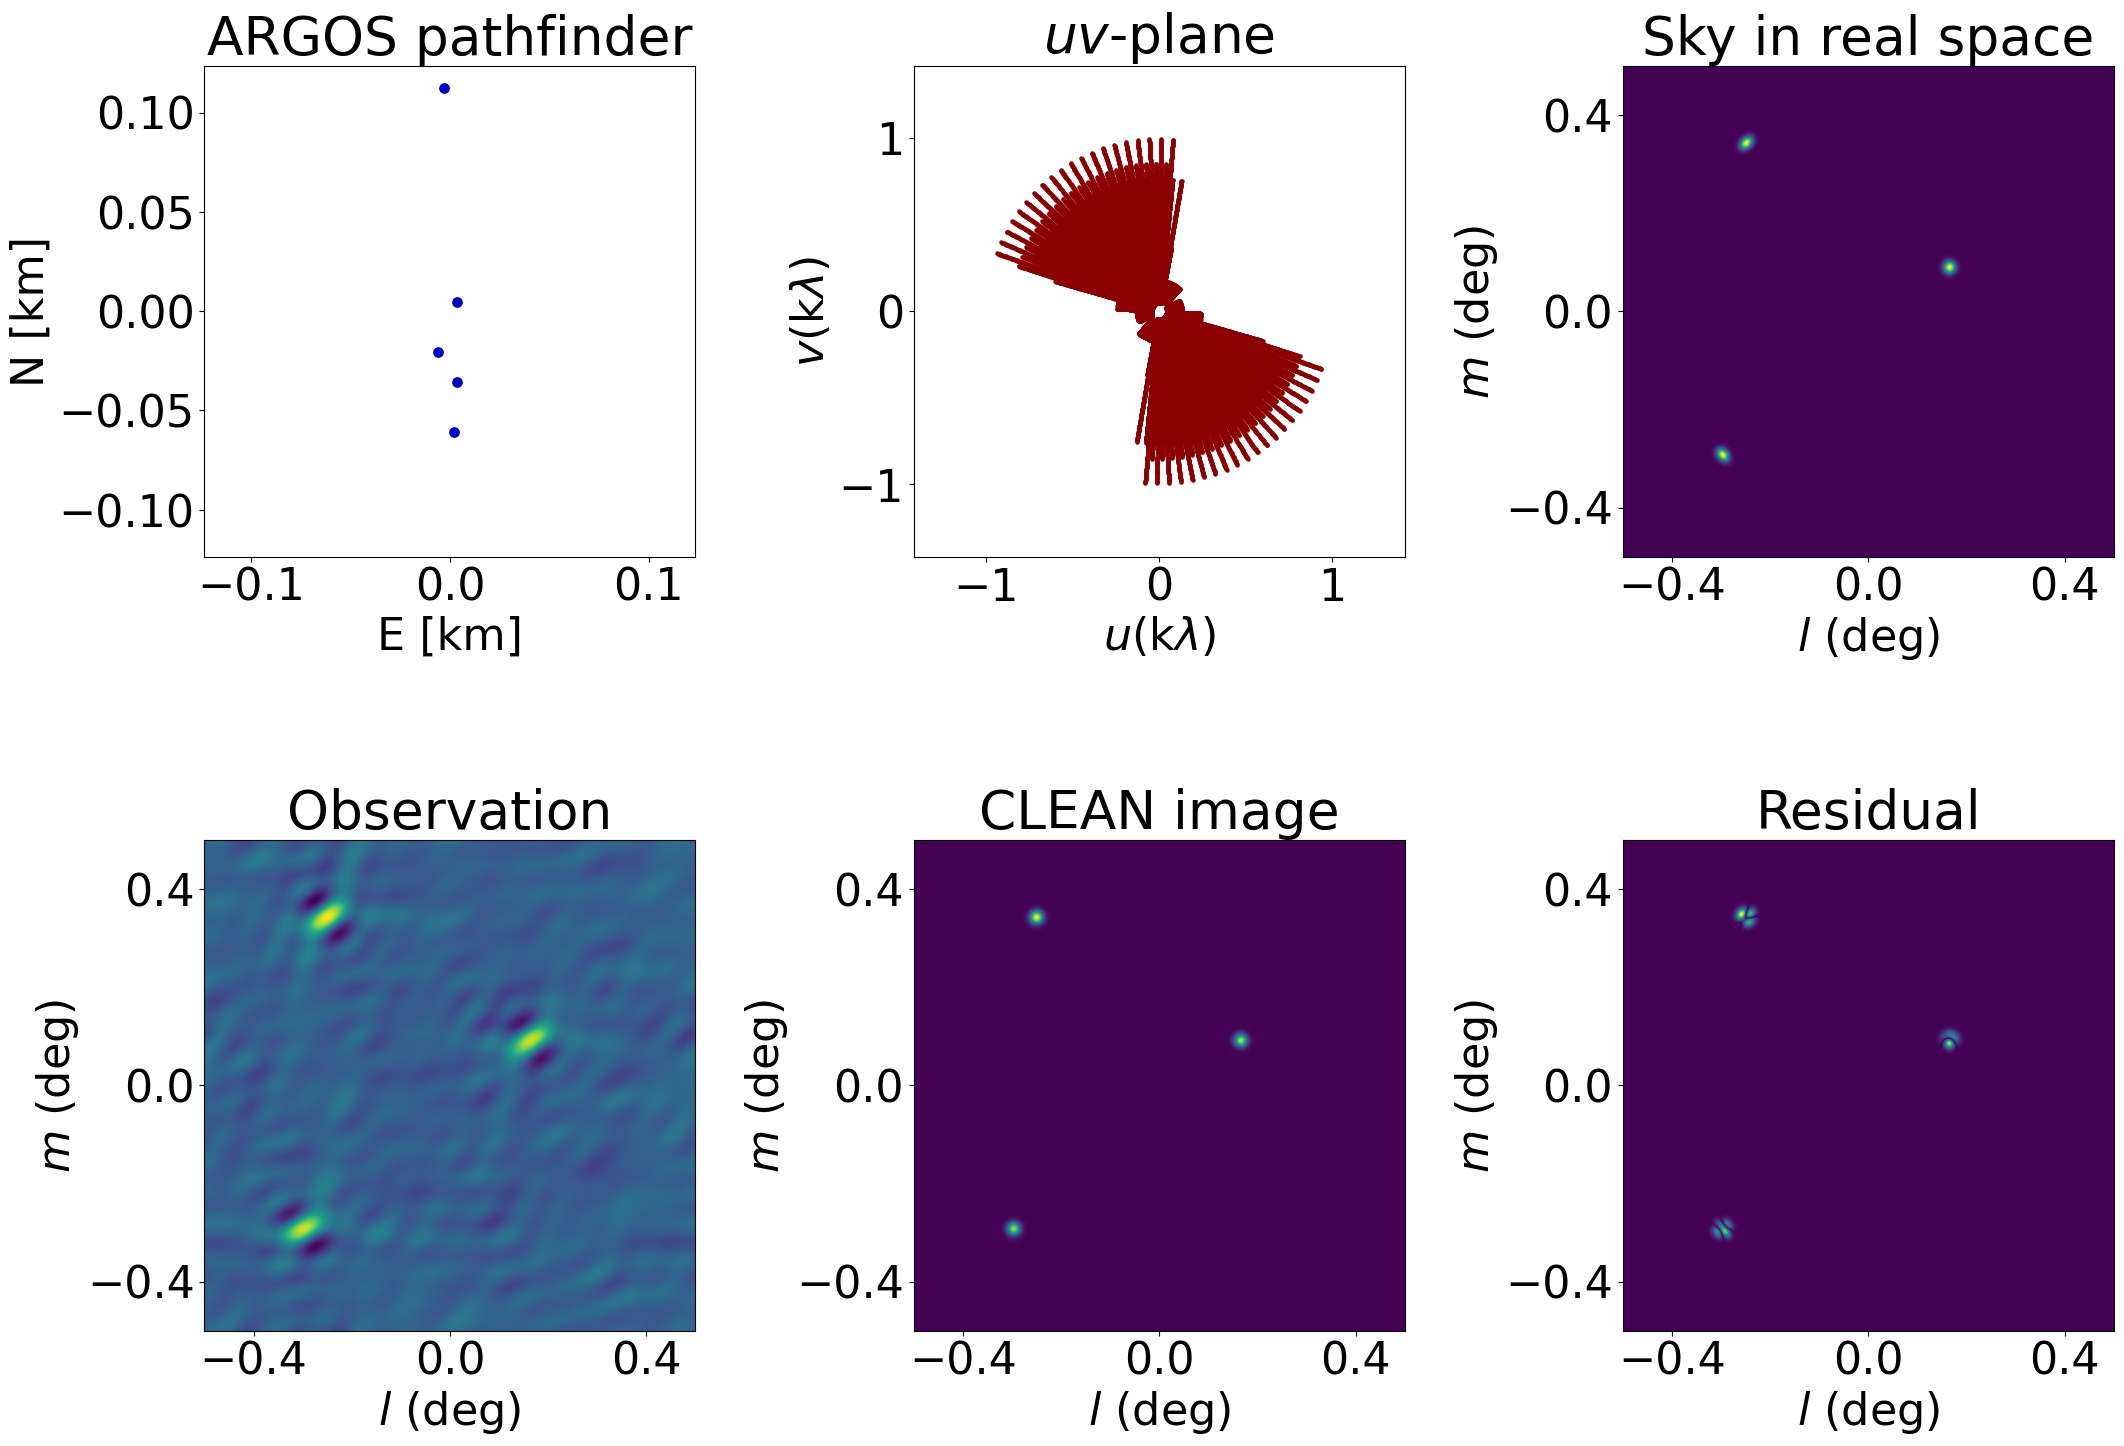

In [ ]:
plt.rcParams.update({'font.size': 32})

fig, ax = plt.subplots(2,3, figsize=(22, 16))
ax = ax.flatten()
plot_antenna_arr(antenna, ax=ax[0], fig=fig, title='ARGOS pathfinder', s=45, antenna_idx=False)
plot_baselines(track, ax=ax[1], fig=fig)
ax[1].set_title(r"$uv$-plane")

ax[2].imshow(np.abs(sky), extent=[-fov_size / 2, fov_size / 2, -fov_size / 2, fov_size / 2], origin="lower")
ax[2].set_xlabel(r"$l$ (deg)")
ax[2].set_ylabel(r"$m$ (deg)")
ax[2].set_title("Sky in real space")
ax[2].set_yticks([-0.4, 0, 0.4])
ax[2].set_xticks([-0.4, 0, 0.4])
ax[3].imshow(observation_single, extent=[-fov_size / 2, fov_size / 2, -fov_size / 2, fov_size / 2], origin="lower")
ax[3].set_xlabel(r"$l$ (deg)")
ax[3].set_ylabel(r"$m$ (deg)")
ax[3].set_title("Observation")
ax[3].set_yticks([-0.4, 0, 0.4])
ax[3].set_xticks([-0.4, 0, 0.4])
ax[4].imshow(I_clean_single, extent=[-fov_size / 2, fov_size / 2, -fov_size / 2, fov_size / 2], origin="lower")
ax[4].set_xlabel(r"$l$ (deg)")
ax[4].set_ylabel(r"$m$ (deg)")
ax[4].set_title("CLEAN image")
ax[4].set_yticks([-0.4, 0, 0.4])
ax[4].set_xticks([-0.4, 0, 0.4])
ax[5].imshow(metrics_single['residual'], extent=[-fov_size / 2, fov_size / 2, -fov_size / 2, fov_size / 2], origin="lower")
ax[5].set_xlabel(r"$l$ (deg)")
ax[5].set_ylabel(r"$m$ (deg)")
ax[5].set_title("Residual")
ax[5].set_yticks([-0.4, 0, 0.4])
ax[5].set_xticks([-0.4, 0, 0.4])
plt.tight_layout()

# plt.savefig('../figures/argos_pathfinder_application.png',bbox_inches='tight')